# UrbanPy model for Florianópolis
Start date: 2022-12-30

Make sure the necessary packages are installed from the `pipenv` file created for this work.

To do this, go to the local directory for this project, and in your terminal run:

`pipenv install`

Then, activate the environment by running 

`pipenv shell`

**Note**: @robcrystalornelas needed to run `brew install gdal` in terminal and then `pip install urbanpy` in this notebook to get code below to run. Issue submitted about installation difficulties [here](https://github.com/EL-BID/urbanpy/issues/18).

In [3]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)


import sys
sys.path.append('..')

import urbanpy as up
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import plotly.express as px 
import osmnx as ox

## Download urban data

We'll begin by downloading data for Florianópolis, Brazil.  Specify the place we'll analyze by name (this is just for displaying on the map we print out below), and then the function ending in _osm gives us the city limits. 

In [6]:
city = 'Florianópolis, Brazil'
flor = up.download.nominatim_osm(city)

Plot the data we downloaded for Florianopolis

Text(0.5, 1.0, 'Florianópolis, Brazil')

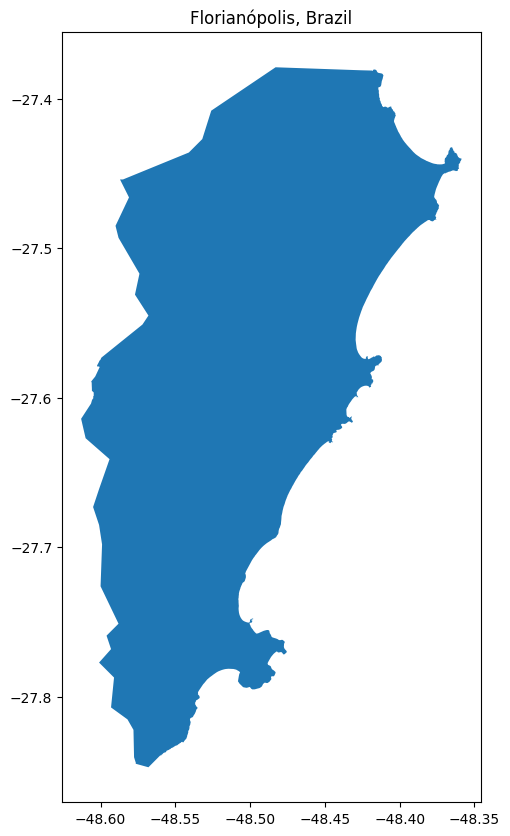

In [7]:
flor.plot()
plt.title(city)

## Divide city into hexagons for spatial analysis

In the function below, the city argument requires a spatial object (for us Florianopolis).
`resolution` argument can be adjusted depending on how many hexagons we want in our grid. 

_Higher numbers means greater resolution and a greater number of cells._

In [18]:
h3_resolution = 8

hex_flor = up.geom.gen_hexagons(h3_resolution, city=flor)

Visualize the city with our hexagons

Text(0.5, 1.0, 'Florianópolis, Brazil. Cells H3 with resolution 8')

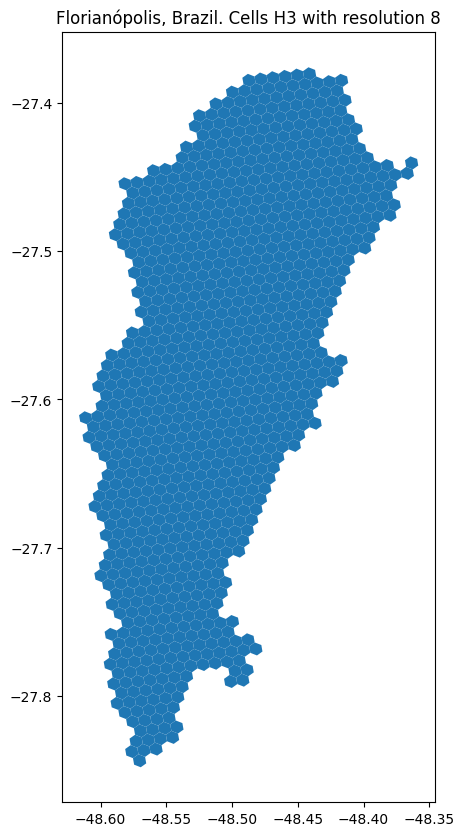

In [19]:
hex_flor.plot()
plt.title(city + ". Cells H3 with resolution " + str(h3_resolution))

Inspect the first few rows of data


In [21]:
hex_flor.head()

,hex,geometry
0,88a91b4739fffff,"POLYGON ((-48.51758 -27.58780, -48.51340 -27.5..."
1,88a91b54b7fffff,"POLYGON ((-48.59866 -27.62910, -48.59448 -27.6..."
2,88a91b55a3fffff,"POLYGON ((-48.52228 -27.63535, -48.51810 -27.6..."
3,88a91b45a7fffff,"POLYGON ((-48.50818 -27.49261, -48.50400 -27.4..."
4,88a91b440dfffff,"POLYGON ((-48.55046 -27.56399, -48.54628 -27.5..."


And see how many rows we have in the dataset. The number of rows (first number below) tells us how many cells florianopolis was divided into

In [24]:
hex_flor.shape

(977, 2)

## Download population data

You can see the data/metadata in HDX UI [here](https://data.humdata.org/dataset/brazil-high-resolution-population-density-maps-demographic-estimates).

We get the population data at the *country* level from a function in `urbanpy`.  First, list the country, then the type of population:

- `full`: entire population **DOES NOT WORK**
- `children`: children (age 0-5)
- `youth`: youth (15-24)
- `elderly`: Ages 60+

So let's start by getting Brazil population data

In [47]:
pop_brazil = up.download.hdx_fb_population('brazil', 'youth')

Take a look at the population data. For Brazil, all these data are from 2019

In [51]:
pop_brazil.head()

,latitude,longitude,population
0,-27.012917,-51.737361,0.767636
1,-27.010139,-51.738750,0.767636
2,-27.009583,-51.740417,0.767636
3,-27.010139,-51.741806,0.767636
4,-27.009306,-51.739028,0.767636


Next, filter for the area of interest. The `filter_population` function works by a bounding box, so not an exact shape of the city of interest


In [53]:
pop_flor = up.geom.filter_population(pop_brazil, flor)

Now visualize the population data. We'll see that the data go beyond the city limits

<AxesSubplot: >

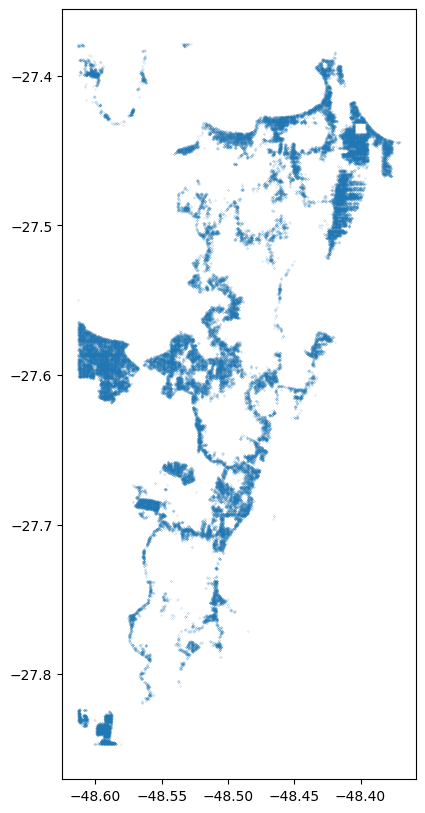

In [59]:
pop_flor.plot(markersize=0.01)

Then, calculate the population per hexagon

In [60]:
hex_flor = up.geom.merge_shape_hex(hex_flor, pop_flor, agg={'population':'sum'})

In [61]:
hex_flor.head()

,hex,geometry,population
0,88a91b4739fffff,"POLYGON ((-48.51758 -27.58780, -48.51340 -27.5...",10.725960
1,88a91b54b7fffff,"POLYGON ((-48.59866 -27.62910, -48.59448 -27.6...",NaN
2,88a91b55a3fffff,"POLYGON ((-48.52228 -27.63535, -48.51810 -27.6...",546.171480
3,88a91b45a7fffff,"POLYGON ((-48.50818 -27.49261, -48.50400 -27.4...",0.386838
4,88a91b440dfffff,"POLYGON ((-48.55046 -27.56399, -48.54628 -27.5...",NaN


## Visualize data on static map

And then look at these data on a map

Text(0.5, 1.0, 'Florianópolis, Brazil. Population 2019')

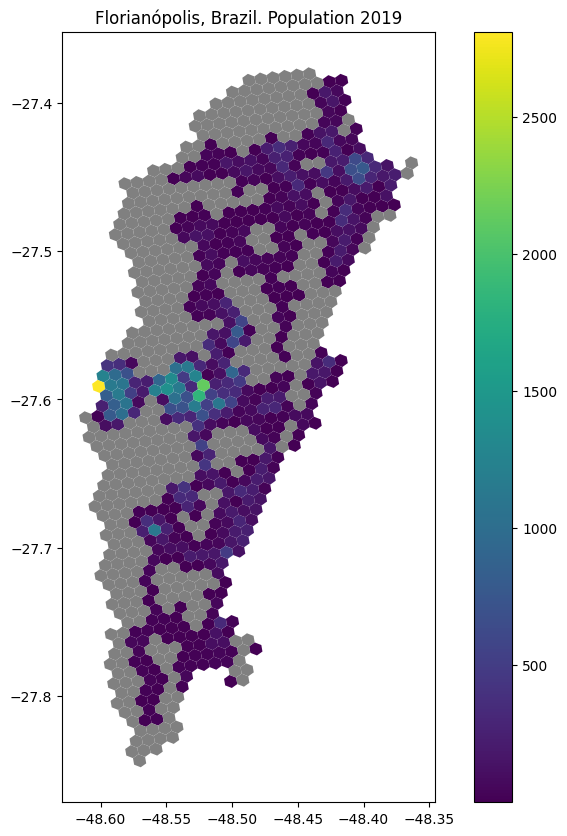

In [62]:
hex_flor.plot('population', legend=True, missing_kwds={'color':'grey'})
plt.title(city + ". Population 2019")

## Visualize data on interactive map

In [63]:
fig = up.plotting.choropleth_map(
    hex_flor, 
    'population', 
    title=city + '. Population - 2019', 
    zoom = 10, 
    color_continuous_scale="Viridis",
    opacity=0.8,
    labels={'population':'Population 2019'}                                 
)

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.show()